In [1]:
import sys
sys.path.append('..')
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [2]:
from src.nf import CalibratedModel, neg_log_likelihood
from src.nf.classifiers import train_catboost_clf, make_clf_dataset
from utils import data_utils

from nflib.flows.sequence import NormalizingFlowModel, InvertiblePermutation
from nflib.flows.affine import AffineConstantFlow, AffineHalfFlow, MAF
from nflib.flows.glow import ActNorm, Invertible1x1Conv
from nflib.flows.spline import NSF_AR

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

from copy import deepcopy

import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

In [3]:
import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
data = data_utils.GAS()

In [6]:
dim = data.n_dims
num_layers = 5

In [7]:
data.trn.x.shape

(852174, 8)

In [8]:
X_train_tensor = torch.from_numpy(data.trn.x).to(device)
X_test_tensor = torch.from_numpy(data.tst.x).to(device)

In [9]:
prior = MultivariateNormal(torch.zeros(dim).to(device), torch.eye(dim).to(device))

flows = []
for i in range(num_layers):
    flows.append(ActNorm(dim))
    flows.append(MAF(dim=dim, hidden_dim=32,
                     context=None,
                     num_masks=1, natural_ordering=True))
    flows.append(Invertible1x1Conv(dim))
model = NormalizingFlowModel(prior, flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.005)


In [10]:
epoches = 50000
plot_freq = 10
metrics_train, metrics_test = [], []
grad_norms1, grad_norms2 = [], []

In [11]:
def get_grad_stats(model):
    total_norm1, total_norm2 = 0, 0
    for p in model.parameters():
        param_norm = p.grad.data.norm(2)
        total_norm2 += param_norm.item() ** 2
        
        total_norm1 += p.grad.data.norm(1)
        
    return total_norm1, (total_norm2 ** 0.5)

In [14]:
from tqdm import tqdm

In [15]:
for epoch in tqdm(range(len(metrics_train) * plot_freq, epoches), position=0):
#     loss = model.ll_train_step(optimizer, X_train_tensor)
    
    model.train()
    optimizer.zero_grad()
    _, logp_x = model.inverse(X_train_tensor)
    loss = -torch.mean(logp_x)
    loss.backward()
    norm1, norm2 = get_grad_stats(model)
    grad_norms1.append(norm1)
    grad_norms2.append(norm2)
#     torch.nn.utils.clip_grad_norm(model.parameters(), 1)
    optimizer.step()

    if epoch % plot_freq == 0:
        metrics_train.append(-neg_log_likelihood(model, X_train_tensor))
        metrics_test.append(-neg_log_likelihood(model, X_test_tensor))
        
        clear_output(False)
        fig, axs = plt.subplots(2, 2, figsize=(15,10))

        print(f'Train log likelihood: {np.mean(metrics_train[-10:])}')
        print(f'Test log likelihood: {np.mean(metrics_test[-10:])}')
        axs[0, 0].plot(np.arange(len(metrics_train)) * plot_freq, metrics_train)
        axs[0, 0].set_title('Train log likelihood')
        axs[0, 1].plot(np.arange(len(metrics_test)) * plot_freq, metrics_test)
        axs[0, 1].set_title('Test log likelihood')
        
        axs[1, 0].plot(np.arange(len(grad_norms1)), grad_norms1)
        axs[1, 0].set_title('L1 norm')
        axs[1, 1].plot(np.arange(len(grad_norms2)), grad_norms2)
        axs[1, 1].set_title('L2 norm')

    plt.show()

  0%|          | 0/50000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Train log likelihood: 9.7496826171875
Test log likelihood: 9.721890449523926


Text(0.5, 1.0, 'L2 norm')

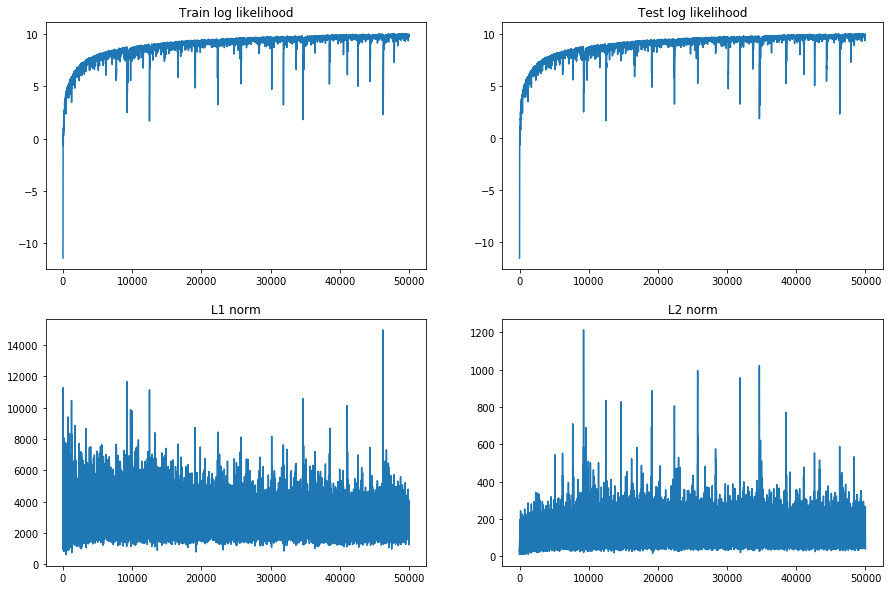

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))

print(f'Train log likelihood: {np.mean(metrics_train[-10:])}')
print(f'Test log likelihood: {np.mean(metrics_test[-10:])}')
axs[0, 0].plot(np.arange(len(metrics_train)) * plot_freq, metrics_train)
axs[0, 0].set_title('Train log likelihood')
axs[0, 1].plot(np.arange(len(metrics_test)) * plot_freq, metrics_test)
axs[0, 1].set_title('Test log likelihood')

axs[1, 0].plot(np.arange(len(grad_norms1)), grad_norms1)
axs[1, 0].set_title('L1 norm')
axs[1, 1].plot(np.arange(len(grad_norms2)), grad_norms2)
axs[1, 1].set_title('L2 norm')

In [17]:
torch.save(model.state_dict(), './GAS/modelBig50k')
torch.save(optimizer.state_dict(), './GAS/optimizerBig50k')

In [18]:
clf_ds_train = make_clf_dataset(X_train_tensor, model)
clf_ds_test = make_clf_dataset(X_test_tensor, model)

/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


In [19]:
clf = CatBoostClassifier(
    1000, eval_metric='AUC',
    metric_period=1,
).fit(
    clf_ds_train[:, :-1], clf_ds_train[:, -1],
    eval_set=(clf_ds_test[:, :-1], clf_ds_test[:, -1])
)

Learning rate set to 0.199115
0:	test: 0.5614375	best: 0.5614375 (0)	total: 481ms	remaining: 8m
1:	test: 0.5734702	best: 0.5734702 (1)	total: 699ms	remaining: 5m 48s
2:	test: 0.5797086	best: 0.5797086 (2)	total: 998ms	remaining: 5m 31s
3:	test: 0.5881689	best: 0.5881689 (3)	total: 1.35s	remaining: 5m 36s
4:	test: 0.5931919	best: 0.5931919 (4)	total: 1.78s	remaining: 5m 55s
5:	test: 0.5953682	best: 0.5953682 (5)	total: 2.09s	remaining: 5m 45s
6:	test: 0.5969623	best: 0.5969623 (6)	total: 2.36s	remaining: 5m 35s
7:	test: 0.5973922	best: 0.5973922 (7)	total: 2.61s	remaining: 5m 23s
8:	test: 0.6007805	best: 0.6007805 (8)	total: 2.95s	remaining: 5m 24s
9:	test: 0.6026057	best: 0.6026057 (9)	total: 3.35s	remaining: 5m 32s
10:	test: 0.6084717	best: 0.6084717 (10)	total: 3.71s	remaining: 5m 34s
11:	test: 0.6107990	best: 0.6107990 (11)	total: 4.08s	remaining: 5m 35s
12:	test: 0.6124124	best: 0.6124124 (12)	total: 4.33s	remaining: 5m 29s
13:	test: 0.6144997	best: 0.6144997 (13)	total: 4.57s	rema

115:	test: 0.7240149	best: 0.7240149 (115)	total: 37.6s	remaining: 4m 46s
116:	test: 0.7249150	best: 0.7249150 (116)	total: 38s	remaining: 4m 46s
117:	test: 0.7254625	best: 0.7254625 (117)	total: 38.3s	remaining: 4m 45s
118:	test: 0.7258061	best: 0.7258061 (118)	total: 38.5s	remaining: 4m 45s
119:	test: 0.7269957	best: 0.7269957 (119)	total: 38.9s	remaining: 4m 44s
120:	test: 0.7275414	best: 0.7275414 (120)	total: 39.3s	remaining: 4m 45s
121:	test: 0.7285349	best: 0.7285349 (121)	total: 39.6s	remaining: 4m 45s
122:	test: 0.7290809	best: 0.7290809 (122)	total: 39.9s	remaining: 4m 44s
123:	test: 0.7294764	best: 0.7294764 (123)	total: 40.2s	remaining: 4m 43s
124:	test: 0.7297604	best: 0.7297604 (124)	total: 40.5s	remaining: 4m 43s
125:	test: 0.7304375	best: 0.7304375 (125)	total: 40.8s	remaining: 4m 43s
126:	test: 0.7307656	best: 0.7307656 (126)	total: 41.2s	remaining: 4m 43s
127:	test: 0.7313208	best: 0.7313208 (127)	total: 41.5s	remaining: 4m 42s
128:	test: 0.7317427	best: 0.7317427 (12

227:	test: 0.7671976	best: 0.7671976 (227)	total: 1m 12s	remaining: 4m 4s
228:	test: 0.7673513	best: 0.7673513 (228)	total: 1m 12s	remaining: 4m 4s
229:	test: 0.7674377	best: 0.7674377 (229)	total: 1m 12s	remaining: 4m 4s
230:	test: 0.7675831	best: 0.7675831 (230)	total: 1m 13s	remaining: 4m 3s
231:	test: 0.7677502	best: 0.7677502 (231)	total: 1m 13s	remaining: 4m 3s
232:	test: 0.7680709	best: 0.7680709 (232)	total: 1m 13s	remaining: 4m 3s
233:	test: 0.7682439	best: 0.7682439 (233)	total: 1m 14s	remaining: 4m 2s
234:	test: 0.7684694	best: 0.7684694 (234)	total: 1m 14s	remaining: 4m 2s
235:	test: 0.7687512	best: 0.7687512 (235)	total: 1m 14s	remaining: 4m 1s
236:	test: 0.7689929	best: 0.7689929 (236)	total: 1m 14s	remaining: 4m 1s
237:	test: 0.7692091	best: 0.7692091 (237)	total: 1m 15s	remaining: 4m
238:	test: 0.7693232	best: 0.7693232 (238)	total: 1m 15s	remaining: 4m
239:	test: 0.7695382	best: 0.7695382 (239)	total: 1m 15s	remaining: 4m
240:	test: 0.7698581	best: 0.7698581 (240)	tota

337:	test: 0.7892041	best: 0.7892041 (337)	total: 1m 43s	remaining: 3m 22s
338:	test: 0.7894408	best: 0.7894408 (338)	total: 1m 43s	remaining: 3m 22s
339:	test: 0.7896186	best: 0.7896186 (339)	total: 1m 44s	remaining: 3m 22s
340:	test: 0.7897273	best: 0.7897273 (340)	total: 1m 44s	remaining: 3m 21s
341:	test: 0.7899321	best: 0.7899321 (341)	total: 1m 44s	remaining: 3m 21s
342:	test: 0.7901799	best: 0.7901799 (342)	total: 1m 44s	remaining: 3m 20s
343:	test: 0.7903545	best: 0.7903545 (343)	total: 1m 45s	remaining: 3m 20s
344:	test: 0.7904686	best: 0.7904686 (344)	total: 1m 45s	remaining: 3m 20s
345:	test: 0.7907149	best: 0.7907149 (345)	total: 1m 45s	remaining: 3m 19s
346:	test: 0.7908430	best: 0.7908430 (346)	total: 1m 45s	remaining: 3m 19s
347:	test: 0.7909885	best: 0.7909885 (347)	total: 1m 46s	remaining: 3m 18s
348:	test: 0.7911460	best: 0.7911460 (348)	total: 1m 46s	remaining: 3m 18s
349:	test: 0.7912120	best: 0.7912120 (349)	total: 1m 46s	remaining: 3m 18s
350:	test: 0.7914928	best

448:	test: 0.8063814	best: 0.8063814 (448)	total: 2m 13s	remaining: 2m 43s
449:	test: 0.8064618	best: 0.8064618 (449)	total: 2m 13s	remaining: 2m 43s
450:	test: 0.8065959	best: 0.8065959 (450)	total: 2m 14s	remaining: 2m 43s
451:	test: 0.8066420	best: 0.8066420 (451)	total: 2m 14s	remaining: 2m 42s
452:	test: 0.8067889	best: 0.8067889 (452)	total: 2m 14s	remaining: 2m 42s
453:	test: 0.8068934	best: 0.8068934 (453)	total: 2m 14s	remaining: 2m 42s
454:	test: 0.8070849	best: 0.8070849 (454)	total: 2m 15s	remaining: 2m 41s
455:	test: 0.8072237	best: 0.8072237 (455)	total: 2m 15s	remaining: 2m 41s
456:	test: 0.8073670	best: 0.8073670 (456)	total: 2m 15s	remaining: 2m 41s
457:	test: 0.8074640	best: 0.8074640 (457)	total: 2m 16s	remaining: 2m 40s
458:	test: 0.8075279	best: 0.8075279 (458)	total: 2m 16s	remaining: 2m 40s
459:	test: 0.8076770	best: 0.8076770 (459)	total: 2m 16s	remaining: 2m 40s
460:	test: 0.8078222	best: 0.8078222 (460)	total: 2m 16s	remaining: 2m 40s
461:	test: 0.8079334	best

558:	test: 0.8177779	best: 0.8177779 (558)	total: 2m 46s	remaining: 2m 11s
559:	test: 0.8178460	best: 0.8178460 (559)	total: 2m 46s	remaining: 2m 11s
560:	test: 0.8179087	best: 0.8179087 (560)	total: 2m 47s	remaining: 2m 10s
561:	test: 0.8179331	best: 0.8179331 (561)	total: 2m 47s	remaining: 2m 10s
562:	test: 0.8181076	best: 0.8181076 (562)	total: 2m 47s	remaining: 2m 10s
563:	test: 0.8181960	best: 0.8181960 (563)	total: 2m 48s	remaining: 2m 9s
564:	test: 0.8183790	best: 0.8183790 (564)	total: 2m 48s	remaining: 2m 9s
565:	test: 0.8184636	best: 0.8184636 (565)	total: 2m 48s	remaining: 2m 9s
566:	test: 0.8184702	best: 0.8184702 (566)	total: 2m 48s	remaining: 2m 8s
567:	test: 0.8185381	best: 0.8185381 (567)	total: 2m 49s	remaining: 2m 8s
568:	test: 0.8186226	best: 0.8186226 (568)	total: 2m 49s	remaining: 2m 8s
569:	test: 0.8186748	best: 0.8186748 (569)	total: 2m 49s	remaining: 2m 8s
570:	test: 0.8186858	best: 0.8186858 (570)	total: 2m 50s	remaining: 2m 7s
571:	test: 0.8188113	best: 0.8188

669:	test: 0.8273489	best: 0.8273489 (669)	total: 3m 19s	remaining: 1m 38s
670:	test: 0.8274307	best: 0.8274307 (670)	total: 3m 19s	remaining: 1m 37s
671:	test: 0.8274628	best: 0.8274628 (671)	total: 3m 19s	remaining: 1m 37s
672:	test: 0.8275067	best: 0.8275067 (672)	total: 3m 19s	remaining: 1m 37s
673:	test: 0.8275803	best: 0.8275803 (673)	total: 3m 20s	remaining: 1m 36s
674:	test: 0.8276997	best: 0.8276997 (674)	total: 3m 20s	remaining: 1m 36s
675:	test: 0.8277649	best: 0.8277649 (675)	total: 3m 20s	remaining: 1m 36s
676:	test: 0.8278299	best: 0.8278299 (676)	total: 3m 20s	remaining: 1m 35s
677:	test: 0.8279212	best: 0.8279212 (677)	total: 3m 21s	remaining: 1m 35s
678:	test: 0.8280317	best: 0.8280317 (678)	total: 3m 21s	remaining: 1m 35s
679:	test: 0.8280776	best: 0.8280776 (679)	total: 3m 21s	remaining: 1m 34s
680:	test: 0.8281020	best: 0.8281020 (680)	total: 3m 22s	remaining: 1m 34s
681:	test: 0.8282286	best: 0.8282286 (681)	total: 3m 22s	remaining: 1m 34s
682:	test: 0.8283169	best

779:	test: 0.8353127	best: 0.8353127 (779)	total: 3m 51s	remaining: 1m 5s
780:	test: 0.8354268	best: 0.8354268 (780)	total: 3m 51s	remaining: 1m 4s
781:	test: 0.8354617	best: 0.8354617 (781)	total: 3m 51s	remaining: 1m 4s
782:	test: 0.8355356	best: 0.8355356 (782)	total: 3m 52s	remaining: 1m 4s
783:	test: 0.8355494	best: 0.8355494 (783)	total: 3m 52s	remaining: 1m 4s
784:	test: 0.8355802	best: 0.8355802 (784)	total: 3m 52s	remaining: 1m 3s
785:	test: 0.8356185	best: 0.8356185 (785)	total: 3m 52s	remaining: 1m 3s
786:	test: 0.8356500	best: 0.8356500 (786)	total: 3m 53s	remaining: 1m 3s
787:	test: 0.8356912	best: 0.8356912 (787)	total: 3m 53s	remaining: 1m 2s
788:	test: 0.8357095	best: 0.8357095 (788)	total: 3m 53s	remaining: 1m 2s
789:	test: 0.8357856	best: 0.8357856 (789)	total: 3m 54s	remaining: 1m 2s
790:	test: 0.8358505	best: 0.8358505 (790)	total: 3m 54s	remaining: 1m 1s
791:	test: 0.8359167	best: 0.8359167 (791)	total: 3m 54s	remaining: 1m 1s
792:	test: 0.8360121	best: 0.8360121 (

891:	test: 0.8418971	best: 0.8418971 (891)	total: 4m 23s	remaining: 31.9s
892:	test: 0.8419936	best: 0.8419936 (892)	total: 4m 23s	remaining: 31.6s
893:	test: 0.8420994	best: 0.8420994 (893)	total: 4m 23s	remaining: 31.3s
894:	test: 0.8422047	best: 0.8422047 (894)	total: 4m 23s	remaining: 31s
895:	test: 0.8422280	best: 0.8422280 (895)	total: 4m 24s	remaining: 30.7s
896:	test: 0.8422779	best: 0.8422779 (896)	total: 4m 24s	remaining: 30.4s
897:	test: 0.8423352	best: 0.8423352 (897)	total: 4m 24s	remaining: 30.1s
898:	test: 0.8424038	best: 0.8424038 (898)	total: 4m 25s	remaining: 29.8s
899:	test: 0.8424523	best: 0.8424523 (899)	total: 4m 25s	remaining: 29.5s
900:	test: 0.8424609	best: 0.8424609 (900)	total: 4m 25s	remaining: 29.2s
901:	test: 0.8425562	best: 0.8425562 (901)	total: 4m 25s	remaining: 28.9s
902:	test: 0.8425937	best: 0.8425937 (902)	total: 4m 26s	remaining: 28.6s
903:	test: 0.8426666	best: 0.8426666 (903)	total: 4m 26s	remaining: 28.3s
904:	test: 0.8427172	best: 0.8427172 (90

In [20]:
calibrated_model = CalibratedModel(clf, model, logit=True)

In [21]:
-neg_log_likelihood(model, X_test_tensor), \
-neg_log_likelihood(calibrated_model, X_test_tensor)

(9.482524871826172, 10.123759911379034)

In [23]:
clf2000 = CatBoostClassifier(
    2000, eval_metric='AUC',
    metric_period=100,
).fit(
    clf_ds_train[:, :-1], clf_ds_train[:, -1],
    eval_set=(clf_ds_test[:, :-1], clf_ds_test[:, -1])
)

calibrated_model2000 = CalibratedModel(clf2000, model, logit=True)

-neg_log_likelihood(model, X_test_tensor), \
-neg_log_likelihood(calibrated_model2000, X_test_tensor)

Learning rate set to 0.147284
0:	test: 0.5614375	best: 0.5614375 (0)	total: 235ms	remaining: 7m 50s
100:	test: 0.7045628	best: 0.7045628 (100)	total: 23.4s	remaining: 7m 20s
200:	test: 0.7436591	best: 0.7436591 (200)	total: 47.4s	remaining: 7m 4s
300:	test: 0.7667396	best: 0.7667396 (300)	total: 1m 10s	remaining: 6m 37s
400:	test: 0.7831022	best: 0.7831022 (400)	total: 1m 34s	remaining: 6m 16s
500:	test: 0.7952795	best: 0.7952795 (500)	total: 1m 57s	remaining: 5m 52s
600:	test: 0.8052449	best: 0.8052449 (600)	total: 2m 21s	remaining: 5m 30s
700:	test: 0.8137035	best: 0.8137035 (700)	total: 2m 44s	remaining: 5m 4s
800:	test: 0.8214523	best: 0.8214523 (800)	total: 3m 6s	remaining: 4m 39s
900:	test: 0.8274346	best: 0.8274346 (900)	total: 3m 33s	remaining: 4m 20s
1000:	test: 0.8332454	best: 0.8332454 (1000)	total: 3m 57s	remaining: 3m 56s
1100:	test: 0.8375064	best: 0.8375064 (1100)	total: 4m 19s	remaining: 3m 31s
1200:	test: 0.8420568	best: 0.8420568 (1200)	total: 4m 43s	remaining: 3m 8s


(9.482524871826172, 10.23026453833975)